In [1]:
# -*- coding: UTF-8 -*- 
from builtins import range
from builtins import object
import numpy as np
import linecache
import math
import os
import gzip
import copy
import numbers
import json as json
import matplotlib.pyplot as plt 
import matplotlib

In [2]:
def _simulate_agn(_agn_walk_start_date, expmjd, tau, time_dilation, sf_u, seed):
        """
    Simulate the u-band light curve for a single AGN

    Parameters
    ----------
    expmjd -- a number or numpy array of dates for the light curver

    tau -- the characteristic timescale of the AGN in days

    time_dilation -- (1+z) for the AGN

    sf_u -- the u-band structure function of the AGN

    seed -- the seed for the random number generator

    Returns
    -------
    a numpy array (or number) of delta_magnitude in the u-band at expmjd
    """

    # calculate the observed frame time

        if not isinstance(expmjd, numbers.Number):
            d_m_out = np.zeros(len(expmjd))
            duration_observer_frame = max(expmjd) - _agn_walk_start_date
        else:
            duration_observer_frame = expmjd - _agn_walk_start_date


        rng = np.random.RandomState(seed)
        dt = tau/100.
        duration_rest_frame = duration_observer_frame/time_dilation
        nbins = int(math.ceil(duration_rest_frame/dt))+1

        time_dexes = np.round((expmjd-_agn_walk_start_date)/(time_dilation*dt)).astype(int)
        time_dex_map = {}
        ct_dex = 0
        if not isinstance(time_dexes, numbers.Number):
            for i_t_dex, t_dex in enumerate(time_dexes):
                if t_dex in time_dex_map:
                    time_dex_map[t_dex].append(i_t_dex)
                else:
                    time_dex_map[t_dex] = [i_t_dex]
            time_dexes = set(time_dexes)
        else:
            time_dex_map[time_dexes] = [0]
            time_dexes = set([time_dexes])

        dx2 = 0.0
        x1 = 0.0
        x2 = 0.0

        dt_over_tau = dt/tau
        es = rng.normal(0., 1., nbins)*math.sqrt(dt_over_tau)
        for i_time in range(nbins):
            #The second term differs from Zeljko's equation by sqrt(2.) because he assumes stdev = sf_u/sqrt(2)
            dx1 = dx2
            dx2 = -dx1*dt_over_tau + sf_u*es[i_time] + dx1
            x1 = x2
            x2 += dt

            if i_time in time_dexes:
                if isinstance(expmjd, numbers.Number):
                    dm_val = ((expmjd-_agn_walk_start_date)*(dx1-dx2)/time_dilation+dx2*x1-dx1*x2)/(x1-x2)
                    d_m_out = dm_val
                else:
                    for i_time_out in time_dex_map[i_time]:
                        local_end = (expmjd[i_time_out]-_agn_walk_start_date)/time_dilation
                        dm_val = (local_end*(dx1-dx2)+dx2*x1-dx1*x2)/(x1-x2)
                        d_m_out[i_time_out] = dm_val

        return d_m_out

In [3]:
def calculate_obs_SF(mjd, flux):
    # structure function
    
    # convert mjd to integer
    mjd = mjd.astype(int).tolist()
    flux = flux.astype(float).tolist()
    #initialize the delta time
    delta = 1
    obs_SF_list = []
    delta_list = []
    obs_len = max(mjd) - min(mjd)
    while delta < obs_len:
        n = min(mjd)
        count = 0
        mag_vals = 0.0
        while n <= max(mjd)-delta:
            if n in mjd and n+delta in mjd: 
                mag_vals += (flux[mjd.index(n+delta)] - flux[mjd.index(n)])**2   
                count +=1
            n = n + delta
        if count>0:
            obs_SF_list.append(np.sqrt(mag_vals/count))
            delta_list.append(delta)  
        delta +=1
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, obs_SF_list, label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('Time lag', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.ylabel('Structure Function (Observed)', fontsize=20)
    return obs_SF_list, delta_list

In [4]:
def calculate_true_SF(obs_SF_list, delta_list, flux, flux_err = []):
    true_SF_list = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
        print(var_noise)
    else:
        var_noise = 0
    for i in obs_SF_list:
        true_SF_list.append(np.sqrt(i**2 - 2*var_noise))
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, true_SF_list,label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('Time lag', fontsize=20)
    plt.legend(fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Structure Function (True)', fontsize=20)
        
    

In [5]:
def caculate_ACF( obs_SF_list, delta_list,flux, flux_err = []):
    #autocorrelation function ACF
    ACF = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
    else:
        var_noise = 0
    var_signal = np.var(flux)
    for i in obs_SF_list:
        ACF.append(1 + (2*var_noise - i**2)/(2*var_signal))
    
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, ACF)
    plt.xlabel('Time lag', fontsize=20)
#     plt.xscale('log')
#     plt.yscale('log')
    plt.ylabel('ACF', fontsize=20)  
    

In [6]:
def plot_PSD(mag):
    #power spectrum density
    from scipy import signal
    freqs, times, spectrogram = signal.spectrogram(mag)
    plt.figure(figsize = (20,10))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title('Spectrogram', fontsize=20)
    plt.ylabel('Frequency band', fontsize=20)
    plt.xlabel('Time window', fontsize=20)
    plt.tight_layout()
    
    freqs, psd = signal.welch(mag)

    plt.figure(figsize = (20,10))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density', fontsize=20)
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Power', fontsize=20)
    plt.tight_layout()

In [19]:
_agn_walk_start_date = 0
params = input('input parameters: ').split(',')
seed = int(params[3])
tau = float(params[4])
sf_u = float(params[5])
sf_g = float(params[6])
sf_r = float(params[7])
sf_i = float(params[8])
sf_z = float(params[9])
sf_y = float(params[10])
redshift = float(params[11])
object_id = params[0].strip()
time_dilation = redshift + 1
SF_dict = {'u':sf_u, 'g':sf_g, 'r':sf_r, 'i':sf_i, 'z':sf_z, 'y':sf_y}


input parameters: 713,1,   0,   2513224,  697.50,  0.3280,  0.2900,  0.2570,  0.2340,  0.2180,  0.2050,  1.8171


In [20]:
expmjd = np.array(list(range(0, 1000,2)))
print(max(expmjd)-min(expmjd))
result_u = _simulate_agn(_agn_walk_start_date, expmjd, tau, time_dilation, sf_u, seed)
result_g = result_u*sf_g/sf_u
result_r = result_u*sf_r/sf_u
result_i = result_u*sf_i/sf_u
result_z = result_u*sf_z/sf_u
result_y = result_u*sf_y/sf_u

998


In [21]:
mag_u = np.zeros(len(expmjd))
mag_g = np.zeros(len(expmjd))
mag_r = np.zeros(len(expmjd))
mag_i = np.zeros(len(expmjd))
mag_z = np.zeros(len(expmjd))
mag_y = np.zeros(len(expmjd))

mag_u[0] = 10
mag_g[0] = 10
mag_r[0] = 10
mag_i[0] = 10
mag_z[0] = 10
mag_y[0] = 10

n = 1
while n<len(result_u):
    mag_u[n] = mag_u[n-1] + result_u[n]
    mag_g[n] = mag_g[n-1] + result_g[n]
    mag_r[n] = mag_r[n-1] + result_r[n]
    mag_i[n] = mag_i[n-1] + result_i[n]
    mag_z[n] = mag_z[n-1] + result_z[n]
    mag_y[n] = mag_y[n-1] + result_y[n]
    n +=1

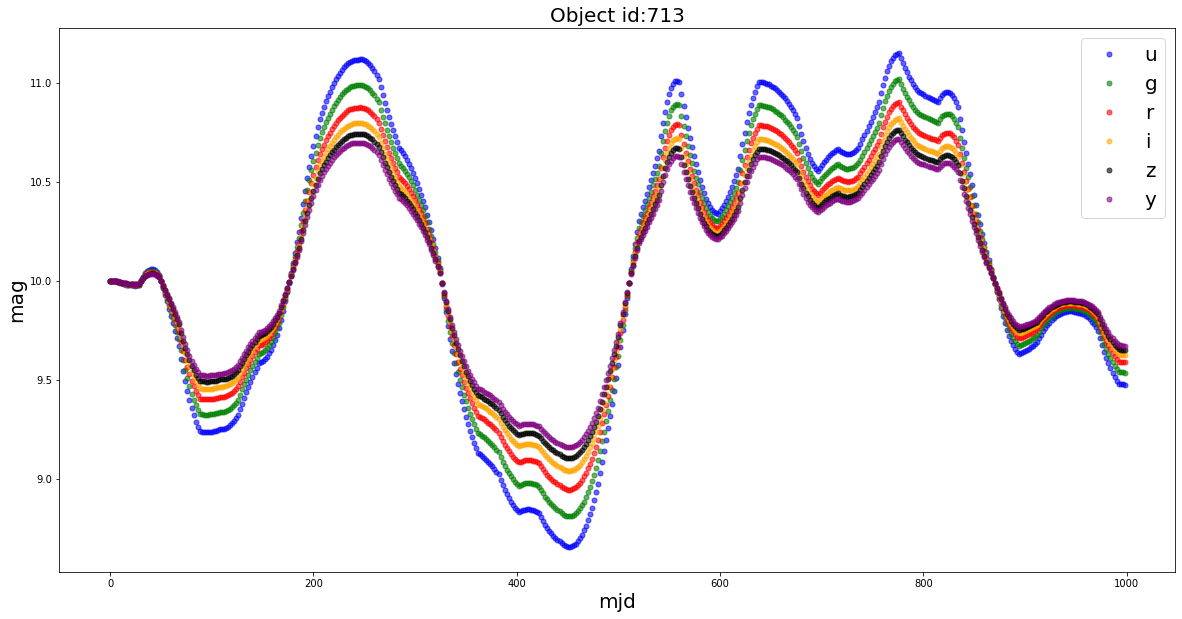

In [30]:

plt.figure(figsize = (20,10))
plt.errorbar(expmjd, mag_u, alpha = 0.6,fmt='o',color='blue',elinewidth=2,capsize=3,ms=5,label = 'u')
plt.errorbar(expmjd, mag_g, alpha = 0.6,fmt='o',ecolor='green',color='green',elinewidth=2,capsize=3,ms=5,label = 'g')
plt.errorbar(expmjd, mag_r, alpha = 0.6,fmt='o',ecolor='r',color='r',elinewidth=2,capsize=3,ms=5,label = 'r')
plt.errorbar(expmjd, mag_i, alpha = 0.6,fmt='o',ecolor='orange',color='orange',elinewidth=2,capsize=3,ms=5,label = 'i')
plt.errorbar(expmjd, mag_z, alpha = 0.6,fmt='o',ecolor='black',color='black',elinewidth=2,capsize=3,ms=5,label = 'z')
plt.errorbar(expmjd, mag_y, alpha = 0.6,fmt='o',ecolor='purple',color='purple',elinewidth=2,capsize=3,ms=5,label = 'y')
plt.legend(fontsize = 20)
plt.title('Object id:' + object_id, fontsize = 20)
plt.xlabel('mjd',fontsize = 20 )
plt.ylabel('mag', fontsize = 20)
plt.show()

In [31]:
# obs_SF_list, delta_list = calculate_obs_SF(expmjd, mag_u)

In [32]:
# calculate_true_SF(obs_SF_list, delta_list, mag_u)

In [33]:
# caculate_ACF(obs_SF_list, delta_list,mag_u)

In [34]:
# plot_PSD(mag_u)

### Use DRW kernel test the simulation

In [35]:
import autograd.numpy as np
import celerite
from celerite import terms
from celerite import GP
from scipy.optimize import minimize

class DRW_kernel(terms.Term):
    # build a Damped Random Walk kernel, a means the standard variance, c means the characteristic timescale
    
	parameter_names = ("log_a", "log_c")
	
	def get_real_coefficients(self, params):
		log_a, log_c = params
        
		return np.exp(log_a)**2, 1.0/np.exp(log_c)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

def GP_lc(mjd, band, band_err, sigma_in, tau_in):
    
    print("True SF infinte: ", sigma_in*np.sqrt(2))
    print("True Tau: ", tau_in)
    kernel = DRW_kernel(log_a = np.log(sigma_in), log_c = np.log(tau_in))
    gp = GP(kernel, mean=np.mean(band))
    gp.compute(mjd, band_err)  

    print("Initial log likelihood: {0}".format(gp.log_likelihood(band)))  
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
    print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
    print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))
    
    #find the maximum likelihood parameters for this model
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(band, gp))
    gp.set_parameter_vector(soln.x)
    
    print(soln)
    
    a_out = gp.get_parameter_dict()['kernel:log_a']
    c_out = gp.get_parameter_dict()['kernel:log_c']
    SF_inft = np.sqrt(2)*np.exp(a_out)
    tau_out = np.exp(c_out)
    
    print("Estimated SF infinte: ", SF_inft)
    print("Estimated Tau: ", tau_out)
    return gp

def predict_lc(gp, mjd, band_name, band, band_err):
    continuous_mjd = np.linspace(min(mjd),max(mjd),2000)
    pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)
    pred_std = np.sqrt(pred_var)
   
    #plot the predicted light curve
    color = "#ff7f0e"
    plt.figure(figsize = (20,10))
    plt.errorbar(mjd, band, yerr=band_err, fmt=".k", capsize=0)
    plt.plot(continuous_mjd, pred_mean, color=color)
    plt.fill_between(continuous_mjd, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none")
    plt.xlabel("mjd (days)",fontsize=20)
    plt.ylabel("flux",fontsize=20)
    plt.title(band_name+' band maximum likelihood prediction',fontsize=20)
    plt.show()
    return pred_mean, pred_std

True SF infinte:  0.328
True Tau:  697.5
Initial log likelihood: 754.3221634676654
parameter_dict:
OrderedDict([('kernel:log_a', -1.461315260877966), ('kernel:log_c', 6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.46131526  6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1017.5886561975192
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02694378,  0.01559783])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 15
   status: 0
  success: True
        x: array([-0.54154732,  7.22169947])
Estimated SF infinte:  0.8228562765580842
Estimated Tau:  1368.8133484145787


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


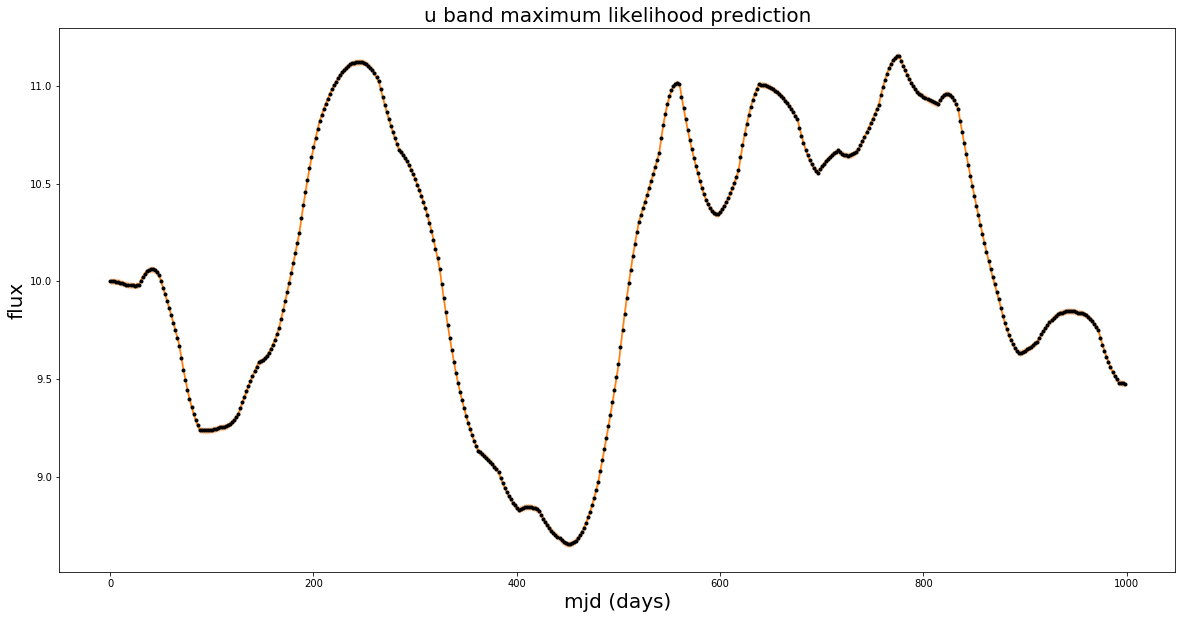

True SF infinte:  0.29
True Tau:  697.5
Initial log likelihood: 815.888506169535
parameter_dict:
OrderedDict([('kernel:log_a', -1.5844479462815901), ('kernel:log_c', 6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.58444795  6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1079.155002008976
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00104592, -0.00034106])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 16
   status: 0
  success: True
        x: array([-0.66609525,  7.21880216])
Estimated SF infinte:  0.7264964634218983
Estimated Tau:  1364.8532012975836


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


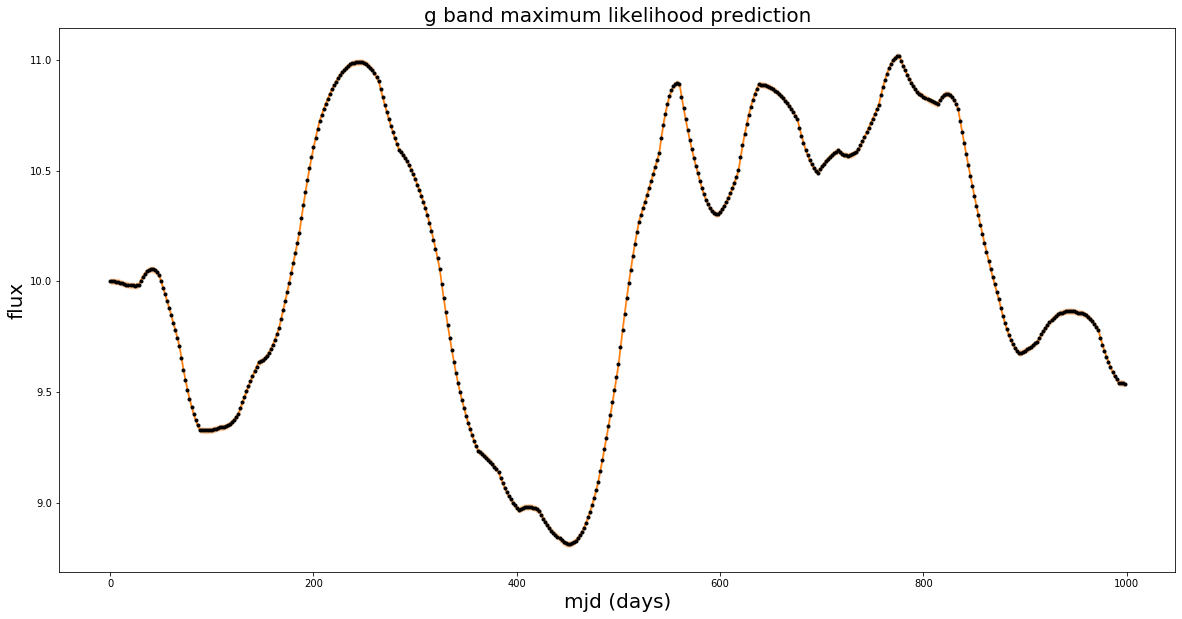

True SF infinte:  0.257
True Tau:  697.5
Initial log likelihood: 876.2909252121569
parameter_dict:
OrderedDict([('kernel:log_a', -1.7052527843668899), ('kernel:log_c', 6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.70525278  6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1139.5574180357005
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03922196, -0.01555236])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 16
   status: 0
  success: True
        x: array([-0.785502  ,  7.22153584])
Estimated SF infinte:  0.6447269334286712
Estimated Tau:  1368.589374892398


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


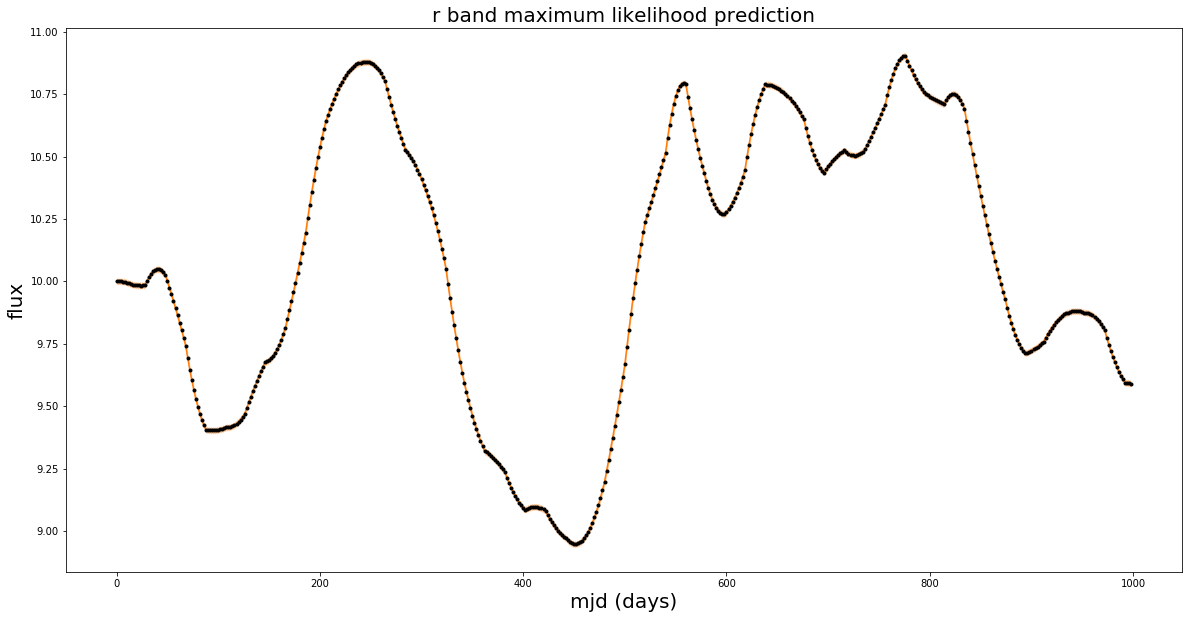

True SF infinte:  0.234
True Tau:  697.5
Initial log likelihood: 923.1684099809306
parameter_dict:
OrderedDict([('kernel:log_a', -1.7990077539044083), ('kernel:log_c', 6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.79900775  6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1186.4349059622689
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00541149,  0.00254659])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 17
   status: 0
  success: True
        x: array([-0.8804151 ,  7.21930026])
Estimated SF infinte:  0.5863481770384433
Estimated Tau:  1365.5332113239047


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


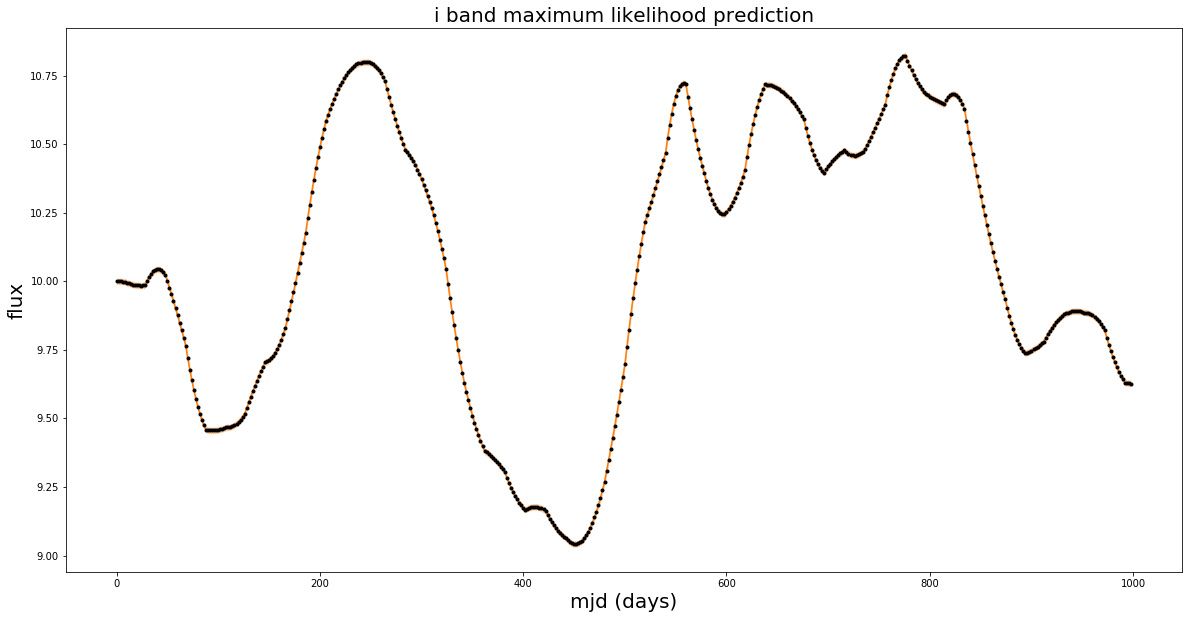

True SF infinte:  0.218
True Tau:  697.5
Initial log likelihood: 958.5814362652186
parameter_dict:
OrderedDict([('kernel:log_a', -1.8698338064730209), ('kernel:log_c', 6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.86983381  6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1221.8479322460616
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00179625, -0.00175078])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 16
   status: 0
  success: True
        x: array([-0.95109195,  7.21957765])
Estimated SF infinte:  0.5463375006849196
Estimated Tau:  1365.912051912575


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


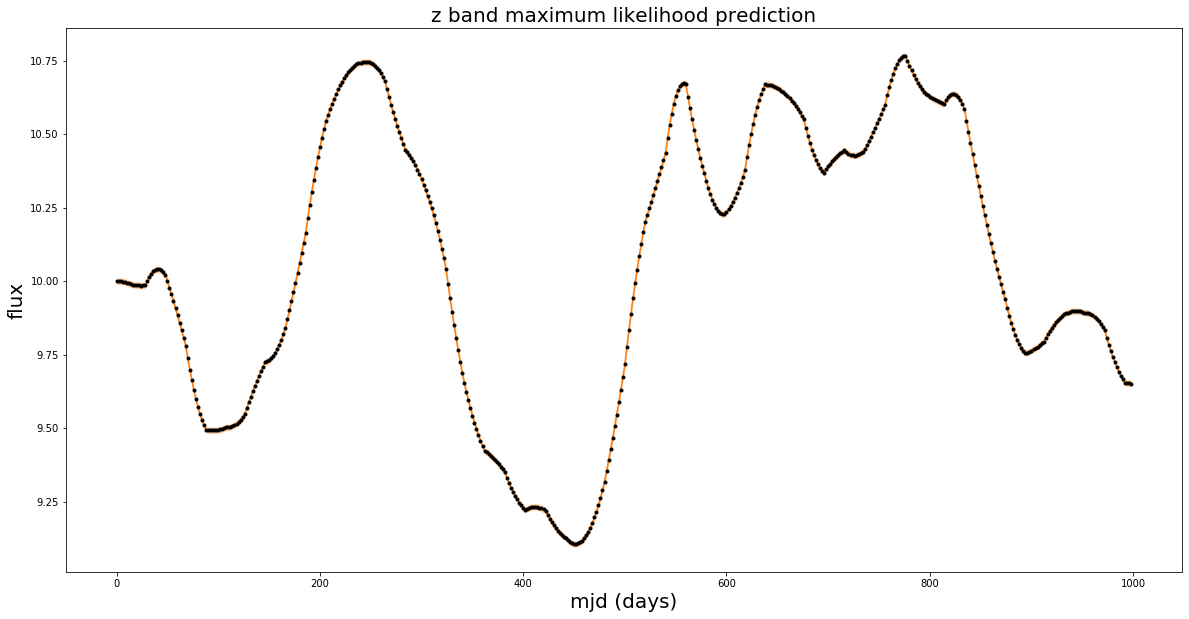

True SF infinte:  0.205
True Tau:  697.5
Initial log likelihood: 989.3239780905869
parameter_dict:
OrderedDict([('kernel:log_a', -1.9313188901237017), ('kernel:log_c', 6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.93131889  6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1252.5904739339053
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00707132, -0.00443379])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 16
   status: 0
  success: True
        x: array([-1.01292323,  7.21887293])
Estimated SF infinte:  0.513579909739119
Estimated Tau:  1364.9497978737488


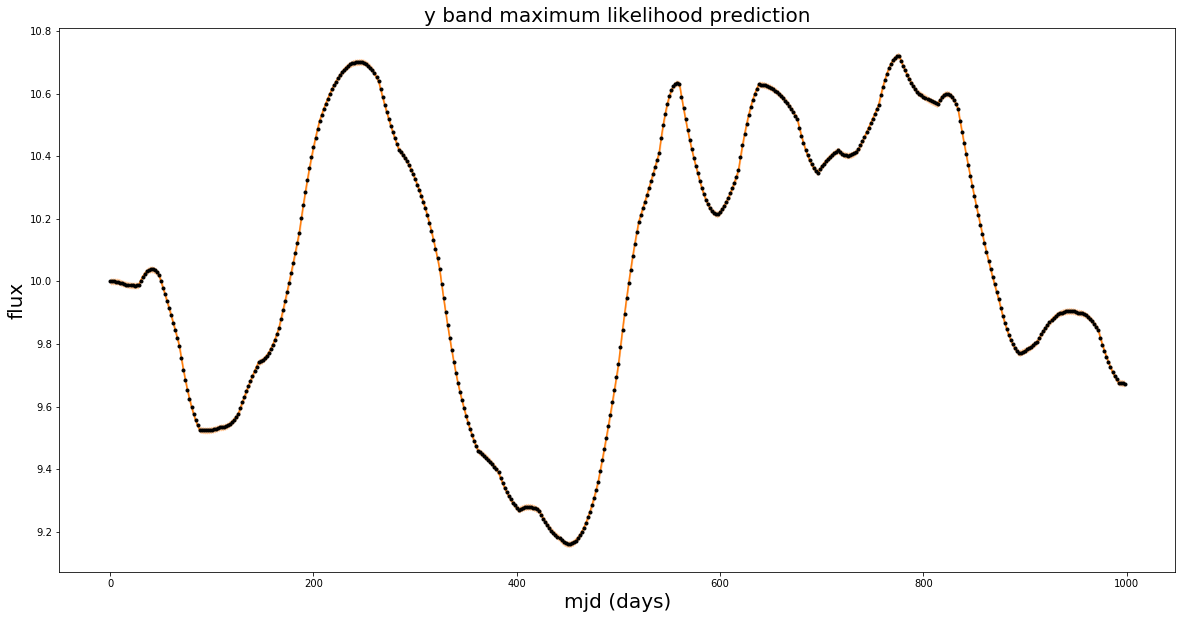

In [37]:
target = {'mjd':expmjd,'u':mag_u, 'g':mag_g,'r':mag_r,'i':mag_i,'z':mag_z,'y':mag_y }
# target = {'mjd':expmjd,'u':result_u, 'g':result_g,'r':result_r,'i':result_i,'z':result_z,'y':result_y }
bands = ['u','g','r','i','z','y']

# print(tau_in)
for i in bands:
    err = np.zeros(len(target['mjd']))
    sigma_in = SF_dict[i]/np.sqrt(2)
    mean_band = np.mean(target[i])
#     target[i] -= mean_band
    gp = GP_lc(target['mjd'], target[i], err, sigma_in, tau)
    predict_lc(gp, target['mjd'], i,target[i],err )


sigma_in 0.231931,  tau_in 697.500000
Initial log likelihood: 754.3221634676654
parameter_dict:
OrderedDict([('kernel:log_a', -2.922630521755932), ('kernel:log_c', -6.5475025136955205)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-2.92263052 -6.54750251]

parameter_bounds:
[(None, None), (None, None)]

      fun: -1017.5886594519952
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00557066, 0.00491127])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 15
   status: 0
  success: True
        x: array([-1.08553823, -7.21918383])
sigma_fit 0.581137,  tau_fit 1365.374233


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


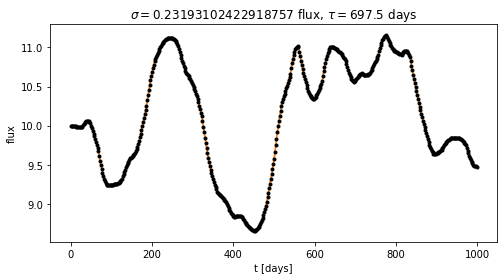

In [38]:
#test
i = 'u'

sigma_in = SF_dict[i] / np.sqrt(2)
tau_in = tau

y_err = 0.001

print("sigma_in %f,  tau_in %f"%(sigma_in,tau_in))

kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , log_c = np.log(1/tau_in))

gp = celerite.GP(kernel, mean=np.mean(target[i]))
gp.compute(target['mjd'], y_err)

# print some info 
print("Initial log likelihood: {0}".format(gp.log_likelihood(target[i])))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))


from scipy.optimize import minimize

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(target[i], gp))
gp.set_parameter_vector(r.x)
print(r)

res = gp.get_parameter_dict()
sigma_out = np.exp(res['kernel:log_a']/2)
tau_out = 1.0/np.exp(res['kernel:log_c'])
print("sigma_fit %f,  tau_fit %f"%(sigma_out,tau_out))


x = np.linspace(min(target['mjd']),max(target['mjd']) , 5000)
pred_mean, pred_var = gp.predict(target[i], x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.errorbar(target['mjd'], target[i], yerr=y_err, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
ax.set_xlabel('t [days]')
ax.set_ylabel('flux')
ax.set_title(r'$\sigma=$'+str(sigma_in)+' flux, '+r'$\tau=$'+str(tau_in)+' days' )
plt.savefig('DRW_simulate_tau_100_sigma_0.2_regular.png', bbox_inches='tight')